# <!-- TITLE --> CNN to recognize an animal
<!-- AUTHOR : Anthony DAVID -->

This CNN recognize between a chihuahua, a crocodile, an elephant, and a goldfish.

The dataset was constructed by using the chrome extension '[image downloader](https://chrome.google.com/webstore/detail/image-downloader/cnpniohnfphhjihaiiggeabnkjhpaldj?hl=en-US)'

# 1 - Preparation of data

## 1.1 - Import python modules

In [1]:
import os, time, sys, pathlib, json, glob
import csv
import math, random
import cv2
import datetime
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import sklearn.metrics

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform
from IPython.display import display,Image,Markdown,HTML


from importlib import reload

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

## 1.2 - Import the dataset, split it into train and validation, and resize the images

In [3]:
data_dir = pathlib.Path('./dataset')
print(os.path.abspath(data_dir))

/Users/anthonydavid/Documents/Etudes/data_scientist/projets/CNN_animals/dataset


In [4]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

789


In [5]:
img_height = 160
img_width = 160

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size = image_count
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size = image_count
  )

class_names = val_data.class_names
print(class_names)
num_classes = len(class_names)

Found 786 files belonging to 4 classes.
Using 629 files for training.
Found 786 files belonging to 4 classes.
Using 157 files for validation.
['chihuahua', 'crocodile', 'elephant', 'poisson_rouge']


In [6]:
# Extract x_train (images) and y_train (labels) from the dataset
x_train = []
y_train = []
for images, labels in train_data:
    x_train.append(images.numpy().astype("uint8"))
    y_train.append(labels)

# Concatenate into tensors and convert to numpy arrays
x_train = tf.concat(x_train, axis=0).numpy()
y_train = tf.concat(y_train, axis=0).numpy()

# Convert integer labels into strings
# y_train = [class_names[label] for label in y_train]

In [7]:
# Extract x_test (images) and y_test (labels) from the dataset
x_test = []
y_test = []
for images, labels in val_data:
    x_test.append(images.numpy().astype("uint8"))
    y_test.append(labels)

# Concatenate into tensors and convert to numpy arrays
x_test = tf.concat(x_test, axis=0).numpy()
y_test = tf.concat(y_test, axis=0).numpy()

# Convert integer labels into strings
# y_test = [class_names[label] for label in y_test]

## 1.3 - Visualizing some resized images

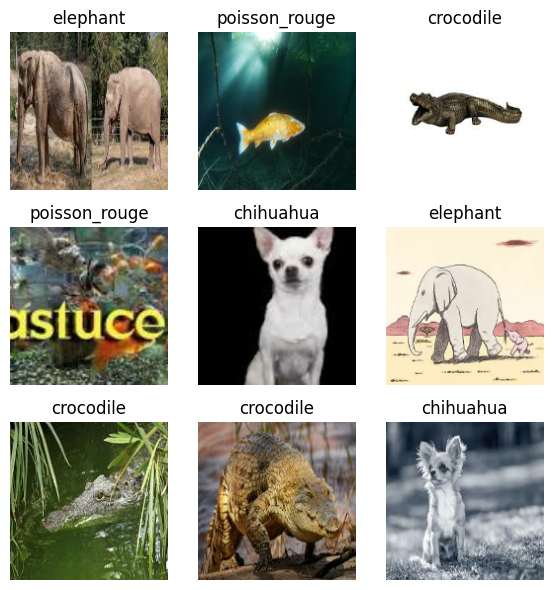

In [8]:
# Create a figure and axis for the grid of images
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.5)

y_train_strings = [class_names[label] for label in y_train]

# Generate and plot the images in a loop
for i in range(9):
    # Generate a random image
    random_label = random.choice(range(len(x_train)))
    image = x_train[random_label]
    name = y_train_strings[random_label]
    
    # Get the current axis and plot the image
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(name)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()

## 1.4 - Create different type of images and visualize the resulting data

Here we use the following type of images : 
 - RGB
 - RGB with histogram equalization
 - Grayscale
 - Grayscale with histogram equalization
 - Grayscale with local histogram equalization
 - Grayscale with Contrast Limited Adaptive Histogram Equalization (CLAHE)
 - Black and White

See : [Exposure with scikit-image](https://scikit-image.org/docs/dev/api/skimage.exposure.html)  
See : [Local histogram equalization](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize)  
See : [Histogram equalization](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist)  

In [9]:
def images_enhancement(images, width=img_width, height=img_height, mode='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    Note : all outputs are fixed size numpy array of float64
    args:
        images :         images list
        width,height :   new images size
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE | BW
    return:
        numpy array of enhanced images
    '''
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1, 'BW':1}
    lz=modes[mode]
    
    out=[]
    for img in images:
        
        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)
            
        # ---- Resize
        img = transform.resize(img, (width,height))


        # ---- RGB / Histogram Equalization
        if mode=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
        # ---- Grayscale
        if mode=='L':
            img=color.rgb2gray(img)
            
        # ---- Grayscale / Histogram Equalization
        if mode=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- Grayscale / Local Histogram Equalization
        if mode=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if mode=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)

        if mode=='BW':
            gray_image = color.rgb2gray(img)
            threshold_value = 0.5  # Adjust this threshold value as needed
            img = np.where(gray_image < threshold_value, 1, 0)

        # ---- Add image in list of list
        out.append(img)

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz)
    return out

### 1.4.1 - Get an idea of the different recipes

dataset : RGB  shape=(16, 160, 160, 3)


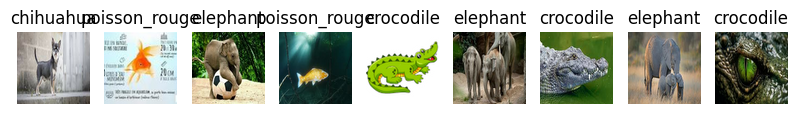

dataset : RGB-HE  shape=(16, 160, 160, 3)


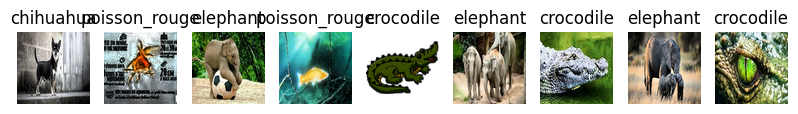

dataset : L  shape=(16, 160, 160, 1)


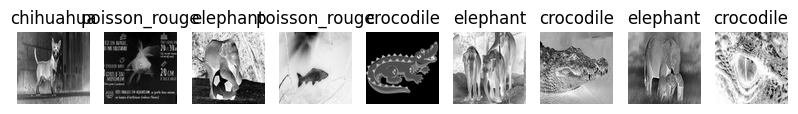

dataset : L-HE  shape=(16, 160, 160, 1)


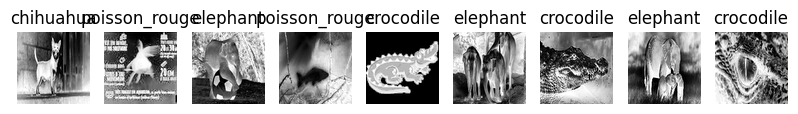

dataset : L-LHE  shape=(16, 160, 160, 1)


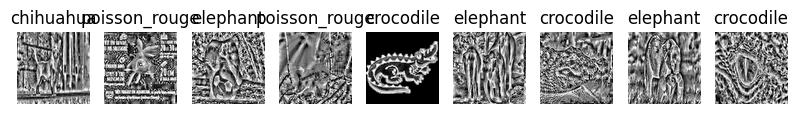

dataset : L-CLAHE  shape=(16, 160, 160, 1)


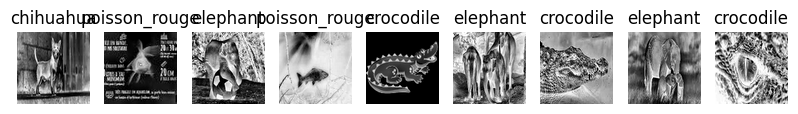

dataset : BW  shape=(16, 160, 160, 1)


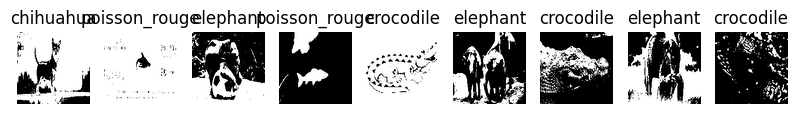

In [10]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]
y_samples_strings = [class_names[label] for label in y_samples]

datasets  = {}

datasets['RGB']      = images_enhancement(x_samples, mode='RGB')
datasets['RGB-HE']   = images_enhancement(x_samples, mode='RGB-HE')
datasets['L']        = images_enhancement(x_samples, mode='L')
datasets['L-HE']     = images_enhancement(x_samples, mode='L-HE')
datasets['L-LHE']    = images_enhancement(x_samples, mode='L-LHE')
datasets['L-CLAHE']  = images_enhancement(x_samples, mode='L-CLAHE')
datasets['BW']       = images_enhancement(x_samples, mode='BW')


# Generate and plot the images in a loop
for k, d in datasets.items():
    # Create a figure and axis for the grid of images
    fig, axes = plt.subplots(1, 9, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.5)

    print("dataset : {}  shape={}".format(k, d.shape))

    for i in range(9):
        image = d[i]
        name = y_samples_strings[i]
        
        # Get the current axis and plot the image
        ax = axes[i % 9]
        ax.imshow(image, cmap='binary', interpolation='lanczos')
        ax.set_title(name)
        ax.axis('off')
        
    # Display the grid of images
    plt.tight_layout()
    plt.show()

## 1.5 - Save the new datasets

A function to save a dataset

In [11]:
def save_h5_dataset(x_train, y_train, x_test, y_test, filename):
        
    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        
    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

In [12]:
output_dir = './data'

In [13]:
n_train = int(len(x_train))
n_test  = int(len(x_test))

display(Markdown(f"<br>**{'Parameters'}**"))
print(f'x_train length is : {n_train}')
print(f'x_test  length is : {n_test}')
print(f'output dir is     : {output_dir}\n')

display(Markdown(f"<br>**{'Running...'}**"))

os.makedirs(output_dir, mode=0o750, exist_ok=True)

for m in ['RGB', 'RGB-HE', 'L', 'L-HE', 'L-LHE', 'L-CLAHE', 'BW']:
    # ---- A nice dataset name
    filename = f'{output_dir}/set-{m}.h5'
    display(Markdown(f"<br>**{filename}**"))
    
    # ---- Enhancement
    #      Note : x_train is a numpy array of python objects (images with <> sizes)
    #             but images_enhancement() return a real array of float64 numpy (images with same size)
    #             so, we can save it in nice h5 files
    #
    x_train_new = images_enhancement(x_train, mode=m)
    x_test_new  = images_enhancement(x_test, mode=m)
        
    # ---- Save
    save_h5_dataset(x_train_new, y_train, x_test_new, y_test, filename)

display(Markdown(f"<br>**{'Done'}**"))

x_train_new, x_test_new=0,0

<br>**Parameters**

x_train length is : 629
x_test  length is : 157
output dir is     : ./data



<br>**Running...**

<br>**./data/set-RGB.h5**

Dataset : ./data/set-RGB.h5         shape : (629, 160, 160, 3)     size :  460.6 Mo   (saved)


<br>**./data/set-RGB-HE.h5**

Dataset : ./data/set-RGB-HE.h5      shape : (629, 160, 160, 3)     size :  460.6 Mo   (saved)


<br>**./data/set-L.h5**

Dataset : ./data/set-L.h5           shape : (629, 160, 160, 1)     size :  153.5 Mo   (saved)


<br>**./data/set-L-HE.h5**

Dataset : ./data/set-L-HE.h5        shape : (629, 160, 160, 1)     size :  153.5 Mo   (saved)


<br>**./data/set-L-LHE.h5**

Dataset : ./data/set-L-LHE.h5       shape : (629, 160, 160, 1)     size :  153.5 Mo   (saved)


<br>**./data/set-L-CLAHE.h5**

Dataset : ./data/set-L-CLAHE.h5     shape : (629, 160, 160, 1)     size :  153.5 Mo   (saved)


<br>**./data/set-BW.h5**

Dataset : ./data/set-BW.h5          shape : (629, 160, 160, 1)     size :  153.5 Mo   (saved)


<br>**Done**

### 1.5.1 - Reload data to be sure

dataset loaded from h5 file.


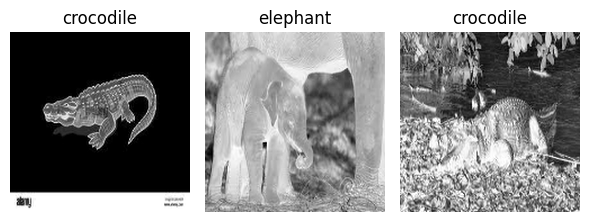

In [14]:
dataset='set-L'

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    y_tmp_strings = [class_names[label] for label in y_tmp]
    print("dataset loaded from h5 file.")

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(1, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.5)

# Generate and plot the images in a loop
for i in range(9):
    # Generate a random image
    random_label = random.choice(range(len(x_tmp)))
    image = x_tmp[random_label]
    name = y_tmp_strings[random_label]
    
    # Get the current axis and plot the image
    ax = axes[i % 3]
    ax.imshow(image, cmap='binary', interpolation='lanczos')
    ax.set_title(name)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()

x_tmp, y_tmp=0,0

# 2 - First convolutions

## 2.1 - Parameters
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [15]:
enhanced_dir = './data'

dataset_name  = 'set-RGB'
batch_size    = 10
epochs        = 20
fit_verbosity = 1

## 2.2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-RGB

In [16]:
# a function to shuffle the dataset

def shuffle_np_dataset(*data):
    """
    Shuffle a list of dataset
    args:
        *data : datasets
    return:
        *datasets mixed
    """
    # print('Datasets have been shuffled.')
    p = np.random.permutation(len(data[0]))
    out = [ d[p] for d in data ]
    return out[0] if len(out)==1 else out


# a function to read the dataset

def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train, y_train = shuffle_np_dataset(x_train, y_train)

    # ---- done
    print(f'Dataset "{dataset_name}" is loaded and shuffled.')
    return x_train, y_train, x_test, y_test

In [17]:
# Read dataset

x_train, y_train, x_test, y_test = read_dataset(enhanced_dir, dataset_name)

(629, 160, 160, 3) (629,)
Dataset "set-RGB" is loaded and shuffled.


## 2.3 - Have a look to the dataset


x_train :  (629, 160, 160, 3)
y_train :  (629,)
x_test  :  (157, 160, 160, 3)
y_test  :  (157,)


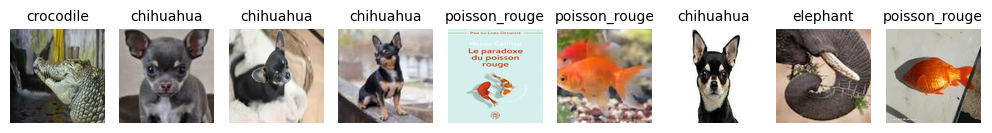

In [18]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

n_figs = 9

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(1, n_figs, figsize=(10, 10))
# fig.subplots_adjust(hspace=.5)
y_train_strings = [class_names[label] for label in y_train]

# Generate and plot the images in a loop
for i in range(n_figs):
    image = x_train[i]
    name = y_train_strings[i]
    
    # Get the current axis and plot the image
    ax = axes[i%n_figs]
    ax.imshow(image, cmap='binary', interpolation='lanczos')
    ax.set_title(name, fontsize=10)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()

## 2.4 - Create model
We will now build a model and train it. We will compare different models latter.

In [19]:
def first_model(lx,ly,lz):
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Dense(num_classes, activation='softmax'))
    return model

## 2.5 - Train the model

**Get the shape of my data :**

In [20]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (160, 160, 3)


**Get and compile a model, with the data shape :**

In [21]:
model = first_model(lx,ly,lz)

model.summary()

model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 79, 79, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 38, 38, 64)        0

**Train it :**

As we need integer labels for y we convert the strings to integers.

In [22]:
# ---- Shuffle train data
x_train, y_train = shuffle_np_dataset(x_train, y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_test, y_test))


Epoch 1/20
63/63 [==============================] - 3s 45ms/step - loss: 1.4996 - accuracy: 0.2639 - val_loss: 1.3692 - val_accuracy: 0.4331
Epoch 2/20
63/63 [==============================] - 3s 40ms/step - loss: 1.2882 - accuracy: 0.3943 - val_loss: 1.2181 - val_accuracy: 0.4841
Epoch 3/20
63/63 [==============================] - 3s 40ms/step - loss: 1.1214 - accuracy: 0.4738 - val_loss: 1.0965 - val_accuracy: 0.5987
Epoch 4/20
63/63 [==============================] - 2s 39ms/step - loss: 1.0143 - accuracy: 0.5453 - val_loss: 1.0842 - val_accuracy: 0.5924
Epoch 5/20
63/63 [==============================] - 2s 40ms/step - loss: 0.9512 - accuracy: 0.5914 - val_loss: 1.0116 - val_accuracy: 0.6242
Epoch 6/20
63/63 [==============================] - 2s 39ms/step - loss: 0.8842 - accuracy: 0.6439 - val_loss: 0.9684 - val_accuracy: 0.6815
Epoch 7/20
63/63 [==============================] - 2s 39ms/step - loss: 0.8032 - accuracy: 0.6789 - val_loss: 0.9330 - val_accuracy: 0.7325
Epoch 8/20
63

## 2.6 - Evaluate

In [23]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.7962


In [24]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.9181
Test accuracy  : 0.7197


# 3 - Tracking and Visualizing

## 3.1 - Parameters

In [25]:
batch_size    = 10
epochs        = 20
fit_verbosity = 1

## 3.2 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard). \
We can use Tensorboard by using the following : \
%load_ext tensorboard \
%tensorboard --logdir /path/to/logs

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [26]:
def tag_now():
    '''
    Return a string tag for current date/time
    args:
        nothing
    return:
        current formated date/time tag as '%Y-%m-%d_%Hh%Mm%Ss'
    '''
    return datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%Ss")

In [27]:
run_dir = './run'
figs_dir = './figs'

os.makedirs(run_dir + '/models', mode=0o750, exist_ok=True)
os.makedirs(run_dir + '/logs', mode=0o750, exist_ok=True)
os.makedirs(figs_dir, mode=0o750, exist_ok=True)

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir /Users/anthonydavid/Documents/Etudes/data_scientist/projets/CNN_animals/run/logs


## 3.3 - Train the model

**Get the shape of my data :**

In [28]:
model = first_model(lx,ly,lz)

# model.summary()

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note: The training curve is visible in real time with Tensorboard

In [29]:
# ---- Shuffle train data
x_train,y_train=shuffle_np_dataset(x_train,y_train)

# ---- Train
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 1.5114 - accuracy: 0.3164

/opt/miniconda3/envs/fidle-env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 8s 130ms/step - loss: 1.5114 - accuracy: 0.3164 - val_loss: 1.3652 - val_accuracy: 0.4713
Epoch 2/20
63/63 [==============================] - 7s 119ms/step - loss: 1.2763 - accuracy: 0.4022 - val_loss: 1.1892 - val_accuracy: 0.5350
Epoch 3/20
63/63 [==============================] - 8s 123ms/step - loss: 1.0515 - accuracy: 0.5199 - val_loss: 1.1527 - val_accuracy: 0.5732
Epoch 4/20
63/63 [==============================] - 7s 119ms/step - loss: 0.9933 - accuracy: 0.5501 - val_loss: 1.0637 - val_accuracy: 0.6242
Epoch 5/20
63/63 [==============================] - 8s 120ms/step - loss: 0.9439 - accuracy: 0.5835 - val_loss: 0.9992 - val_accuracy: 0.6051
Epoch 6/20
63/63 [==============================] - 8s 121ms/step - loss: 0.8608 - accuracy: 0.6423 - val_loss: 0.9789 - val_accuracy: 0.6051
Epoch 7/20
63/63 [==============================] - 7s 117ms/step - loss: 0.8266 - accuracy: 0.6375 - val_loss: 0.9334 - val_accuracy: 0.7070
Epoch 8/20
63/63 

**Evaluate it :**

In [30]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.7580


In [31]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.8652
Test accuracy  : 0.7580


## 3.4 - History
The return of model.fit() returns us the learning history

In [32]:
# Load and use the TensorBoard notebook extension
# %load_ext tensorboard

In [33]:
# !tensorboard --logdir /Users/anthonydavid/Documents/Etudes/data_scientist/projets/CNN_animals/run/logs --port=8008

In [34]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        plt.savefig(figs_dir+'/'+figname+'.png')
        plt.show()


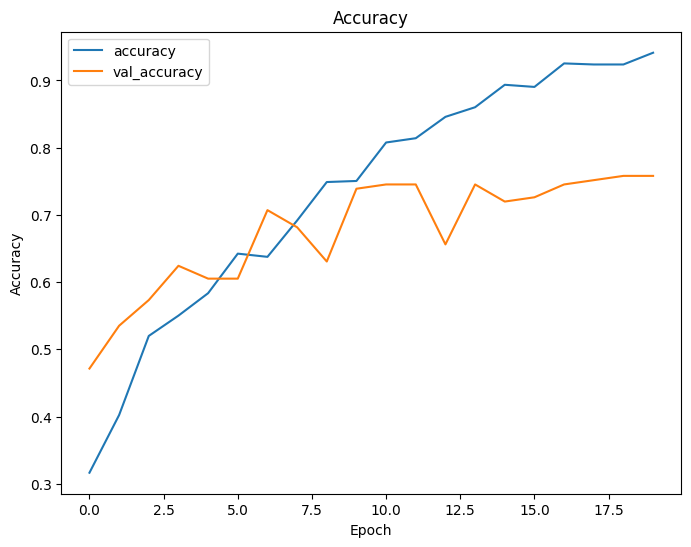

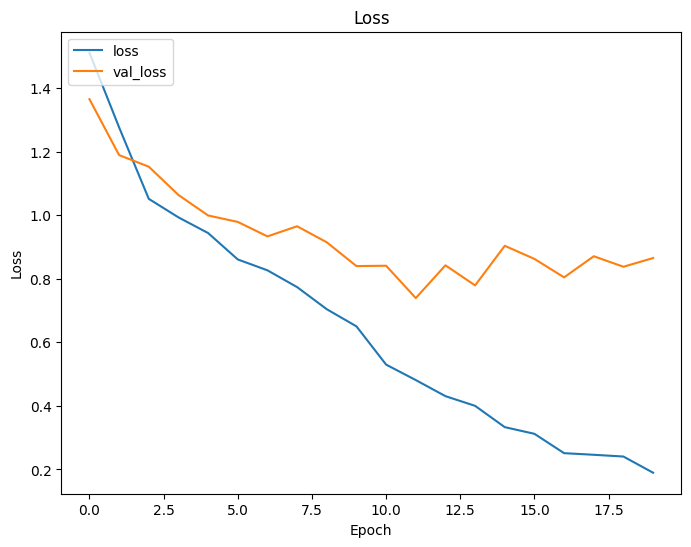

In [35]:
plot_history(history, save_as='history')

## 3.5 - Evaluation and confusion

In [36]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    target_names = [class_names[label] for label in range(len(class_names))]

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    figname=f'{save_as}'
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(figs_dir+'/'+figname+'.png')
    plt.show()


5/5 [==============================] - 0s 24ms/step


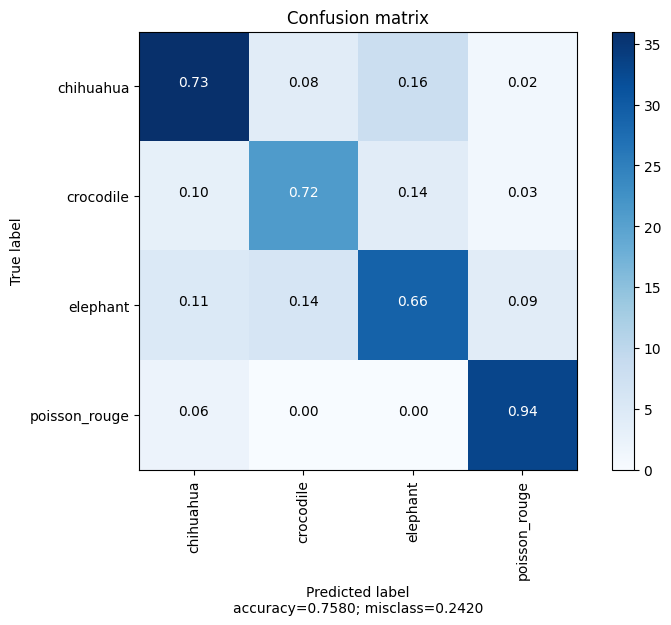

In [37]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

## 3.6 - Restore and evaluate

### 3.6.1 - List saved models :

In [38]:
!find "$run_dir"/models/

./run/models/
./run/models//model-0017.h5
./run/models//model-0007.h5
./run/models//model-0013.h5
./run/models//model-0003.h5
./run/models//model-0012.h5
./run/models//model-0002.h5
./run/models//model-0016.h5
./run/models//model-0006.h5
./run/models//model-0019.h5
./run/models//model-0009.h5
./run/models//model-0018.h5
./run/models//model-0008.h5
./run/models//best-model.h5
./run/models//model-0011.h5
./run/models//last-model.h5
./run/models//model-0001.h5
./run/models//model-0015.h5
./run/models//model-0005.h5
./run/models//model-0020.h5
./run/models//model-0014.h5
./run/models//model-0004.h5
./run/models//model-0010.h5


### 3.6.2 - Restore a model :

In [39]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 3.6.3 - Evaluate it :

In [40]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.8652
Test accuracy  : 0.7580


5/5 [==============================] - 0s 25ms/step


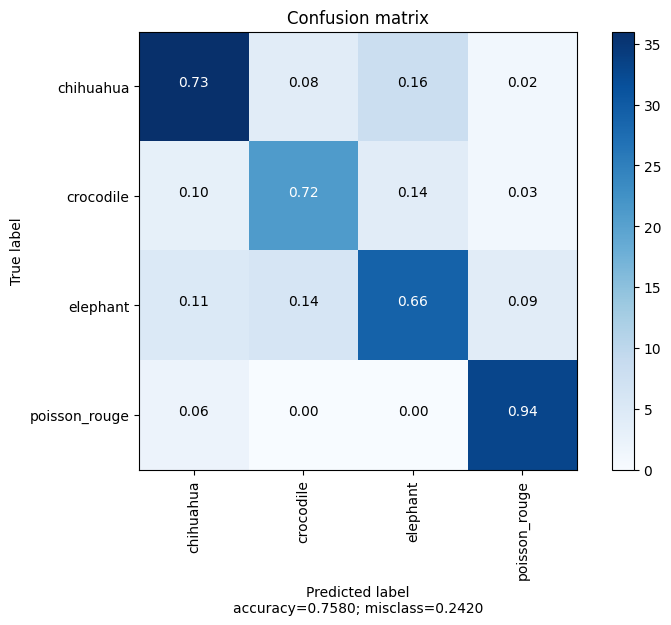

In [41]:
y_sigmoid = loaded_model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

### 3.6.4 - Make a prediction :

In [42]:
# Define parameters for loading the dataset
# batch_size = 1  # One image per class
image_size = (200, 200)  # Size of images in the dataset
directory_path = './dataset_meta'

# Create the meta dataset using image_dataset_from_directory
meta_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    batch_size=num_classes,
    image_size=image_size,
    shuffle=False,  # No need to shuffle, as one image per class
)

# Print class names
meta_class_names = meta_dataset.class_names
print("Meta lass names:", meta_class_names)

x_meta = []
y_meta = []
for images, labels in meta_dataset:
    x_meta.append(images.numpy().astype("uint8"))
    y_meta.append(labels)

# Concatenate into tensors and convert to numpy arrays
x_meta = tf.concat(x_meta, axis=0).numpy()
y_meta = tf.concat(y_meta, axis=0).numpy()

Found 4 files belonging to 4 classes.
Meta lass names: ['chihuahua', 'crocodile', 'elephant', 'poisson_rouge']


1/1 [==============================] - 0s 51ms/step

Output layer from model is (x100) :

[[ 7.16  0.5  92.23  0.12]]

Graphically :



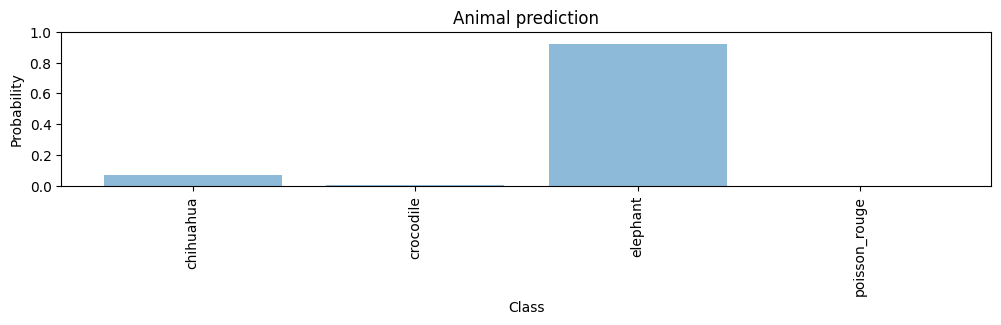


The image :                         Prediction :                      Real stuff:


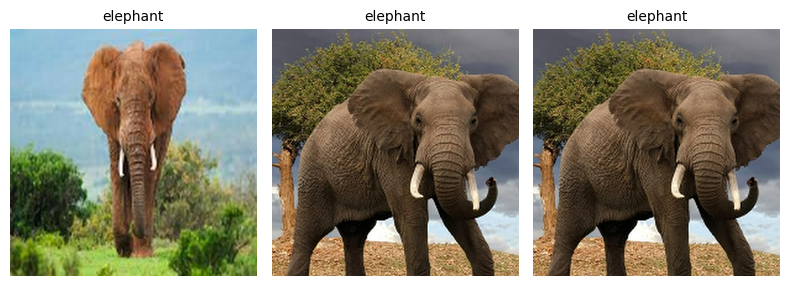

YEEES ! that's right!


In [43]:
# ---- Get a random image
#
i    = random.randint(1,len(x_test))
x, y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict(np.array([x]))

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(num_classes), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))

target_names = [class_names[label] for label in range(len(class_names))]
tick_marks = np.arange(len(target_names))

plt.xticks(tick_marks, target_names, rotation=90)
plt.xlabel('Class')
plt.title('Animal prediction')
plt.savefig(figs_dir+'/prediction-proba.png')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :                         Prediction :                      Real stuff:")

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(1, 3, figsize=(8, 6))
# fig.subplots_adjust(hspace=.5)
x_list = [x, x_meta[p], x_meta[y]]
y_list_strings = [class_names[label] for label in [y, p, y]]
# Generate and plot the images in a loop
for i in range(3):
    image = x_list[i]
    name = y_list_strings[i]
    
    # Get the current axis and plot the image
    ax = axes[i%n_figs]
    ax.imshow(image, cmap='binary', interpolation='lanczos')
    ax.set_title(name, fontsize=10)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.savefig(figs_dir+'/prediction-images.png')
plt.show()

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong :(")

# 4 - Data augmentation

## 4.1 - Parameters, Model, and Callbacks  

### 4.1.1 - Parameters

In [44]:
batch_size    = 10
epochs        = 30
fit_verbosity = 1

### 4.1.2 - Model

In [45]:
def first_model_augmented(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.RandomFlip('horizontal'))
    model.add( keras.layers.RandomRotation(0.2))
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Dense(num_classes, activation='softmax'))
    return model

### 4.1.3 - Callbacks
We prepare 2 kind callbacks :  TensorBoard and Best Model backup

In [46]:
run_dir = './run_augmented'
figs_dir = './figs_augmented'

os.makedirs(run_dir + '/models', mode=0o750, exist_ok=True)
os.makedirs(run_dir + '/logs', mode=0o750, exist_ok=True)
os.makedirs(figs_dir, mode=0o750, exist_ok=True)

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir /Users/anthonydavid/Documents/Etudes/data_scientist/projets/CNN_animals/run_augmented/logs


## 4.2 - Data generator

### 4.2.1 - Generate the new images

In [47]:
"""
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen = keras.preprocessing.image.ImageDataGenerator(
    # rescale=1.0/255.0,           # Rescale pixel values to [0, 1]
    rotation_range=10.,           # Random rotation up to 20 degrees
    width_shift_range=0.1,       # Random horizontal shift by 20% of the width
    height_shift_range=0.1,      # Random vertical shift by 20% of the height
    shear_range=0.2,             # Random shear transformations
    zoom_range=0.2,              # Random zoom in/out
    horizontal_flip=True,        # Random horizontal flips
    fill_mode='nearest'          # Fill mode for newly created pixels
)

datagen.fit(x_train)
"""

### Let's try another method
# In the model 'first_model_augmented' we used the following layers for data augmentation : 

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### 4.2.2 - Visualize the generated images

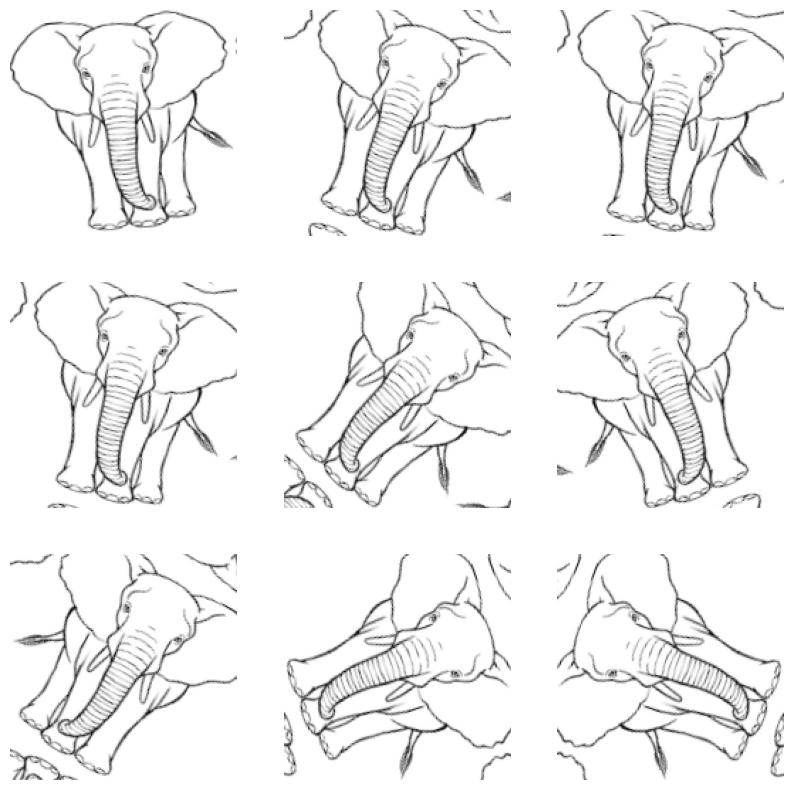

In [48]:
"""
# ---- Get a random image
#
i    = random.randint(1, len(x_train))
x, y = x_train[i], x_train[i]

# Reshape the image to fit the datagen flow
sample_image = np.expand_dims(x, axis=0)

# Generate augmented images
augmented_images = datagen.flow(sample_image, batch_size=1)

# Visualize the augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    augmented_image = augmented_images.next()[0]
    axes[i].imshow(augmented_image)
    axes[i].axis('off')

plt.show()
"""

for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 4.3 - Train the model
**Get my data shape :**

In [49]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (160, 160, 3)


**Get and compile a model, with the data shape :**

In [50]:
model = first_model_augmented(lx,ly,lz)

# model.summary()

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :** 

In [51]:
"""
train_generator = datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    shuffle=True  # Don't shuffle the data during training
)

history = model.fit(  train_generator,
                      steps_per_epoch = len(x_train) // batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )
"""

history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 1.4651 - accuracy: 0.2973

/opt/miniconda3/envs/fidle-env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 10s 145ms/step - loss: 1.4651 - accuracy: 0.2973 - val_loss: 1.3598 - val_accuracy: 0.4713
Epoch 2/30
63/63 [==============================] - 8s 128ms/step - loss: 1.1840 - accuracy: 0.4134 - val_loss: 1.1140 - val_accuracy: 0.5096
Epoch 3/30
63/63 [==============================] - 8s 128ms/step - loss: 1.0601 - accuracy: 0.5024 - val_loss: 1.0721 - val_accuracy: 0.5223
Epoch 4/30
63/63 [==============================] - 8s 131ms/step - loss: 1.0437 - accuracy: 0.5199 - val_loss: 1.0597 - val_accuracy: 0.6242
Epoch 5/30
63/63 [==============================] - 8s 127ms/step - loss: 1.0335 - accuracy: 0.5103 - val_loss: 1.0683 - val_accuracy: 0.4586
Epoch 6/30
63/63 [==============================] - 8s 130ms/step - loss: 1.0088 - accuracy: 0.5342 - val_loss: 1.0598 - val_accuracy: 0.5350
Epoch 7/30
63/63 [==============================] - 8s 128ms/step - loss: 0.9779 - accuracy: 0.5374 - val_loss: 1.0089 - val_accuracy: 0.6115
Epoch 8/30
63/63

**Evaluate it :**

In [52]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.7771


In [53]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.6644
Test accuracy  : 0.7389


## 4.4 - History
The return of model.fit() returns us the learning history

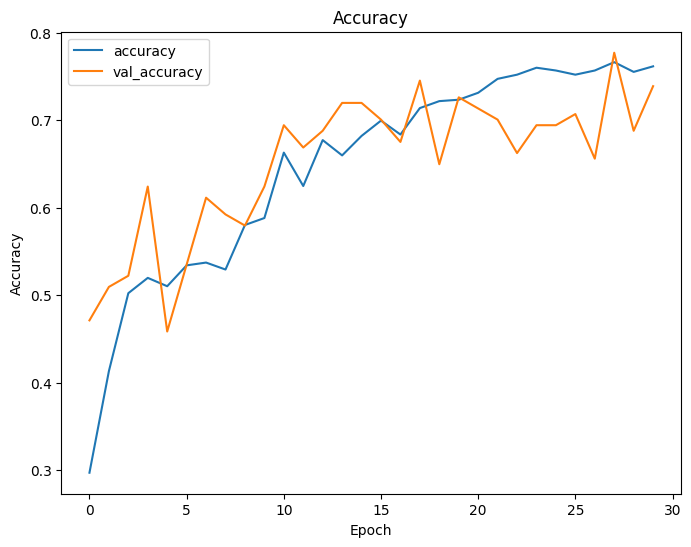

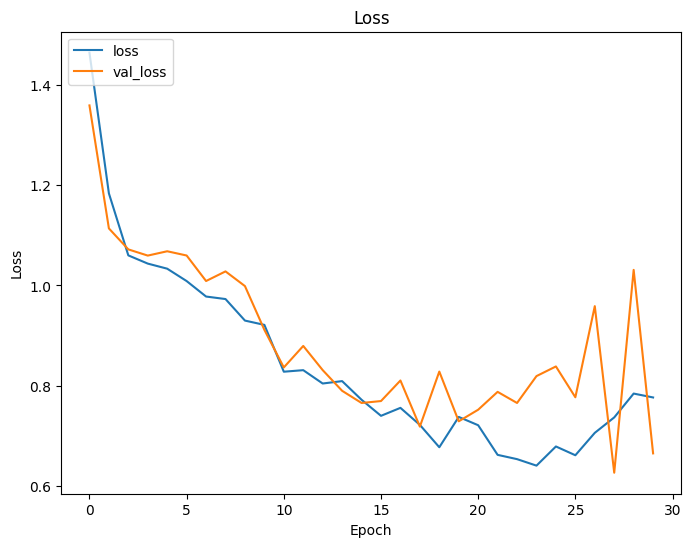

In [54]:
plot_history(history, save_as='history')

## 4.5 - Evaluate best model

### 4.5.1 - Restore best model :

In [55]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 4.5.2 - Evaluate it :

In [56]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.6258
Test accuracy  : 0.7771


**Plot confusion matrix**

5/5 [==============================] - 0s 26ms/step


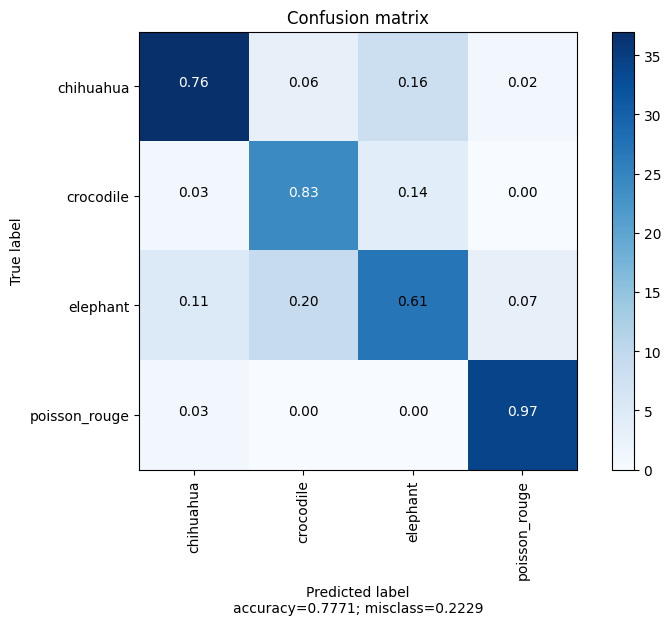

In [57]:
y_sigmoid = loaded_model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

# 5 - Full convolutions

Here we will use many models with many datasets and then show a report in the next section.

## 5.1 - Parameters

In [66]:
enhanced_dir = f'./data'
run_dir = './run_full'

# ---- 
datasets      = ['set-BW', 'set-L', 'set-L-HE', 'set-L-LHE', 'set-L-CLAHE', 'set-RGB', 'set-RGB-HE']
models        = {'v1':'get_model_v1', 'v2':'get_model_v2', 'v3':'get_model_v3', 'v4':'get_model_v4'}
batch_size    = 10
epochs        = 20
with_datagen  = True
fit_verbosity = 0
tag_id = '{:06}'.format(random.randint(0,99999))

## 5.2 - Dataset loading

In [67]:
def shuffle_np_dataset(*data):
    """
    Shuffle a list of dataset
    args:
        *data : datasets
    return:
        *datasets mixed
    """
    # print('Datasets have been shuffled.')
    p = np.random.permutation(len(data[0]))
    out = [ d[p] for d in data ]
    return out[0] if len(out)==1 else out


def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset from dataset_dir
    Args:
        dataset_dir : datasets dir
        name        : dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    # size     = os.path.getsize(filename)/(1024*1024)

    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]

    # ---- Shuffle
    x_train,y_train=shuffle_np_dataset(x_train,y_train)

    # ---- done
    return x_train,y_train,x_test,y_test

## 5.3 - Models collection

In [68]:
def get_model_v1(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.4))
    model.add( keras.layers.Dense(num_classes, activation='softmax'))
    return model


def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.4))

    model.add( keras.layers.Dense(num_classes, activation='softmax'))
    return model


def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    
    model.add( keras.layers.GlobalAveragePooling2D())
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.4))

    model.add( keras.layers.Dense(num_classes, activation='softmax'))
    return model


def get_model_v4(lx,ly,lz):
    model = keras.models.Sequential()

    model.add(keras.layers.Conv2D(128, 4, activation='relu', input_shape=(lx,ly,lz)))
    model.add(keras.layers.MaxPooling2D())
    
    model.add(keras.layers.Conv2D(64, 4, activation='relu'))
    model.add(keras.layers.MaxPooling2D())

    model.add(keras.layers.Conv2D(32, 4, activation='relu'))
    model.add(keras.layers.MaxPooling2D())

    model.add(keras.layers.Conv2D(16, 4, activation='relu'))
    model.add(keras.layers.MaxPooling2D())

    model.add(keras.layers.Flatten()) 
    model.add(keras.layers.Dense(64, activation='relu'))

    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    return model


def get_model_v5(lx,ly,lz):
    model = keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same',  activation='relu', input_shape=(lx,ly,lz)))
    model.add(tf.keras.layers.BatchNormalization(axis=-1))      
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same',  activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(axis=-1))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(axis=-1))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

## 5.4 - Prepare the multi-run

In [69]:
def multi_run(enhanced_dir, datasets, models, datagen=None, 
              batch_size=batch_size, epochs=epochs, 
              fit_verbosity=0, tag_id='last'):
    """
    Launches a dataset-model combination
    args:
        enhanced_dir   : Directory of the enhanced datasets
        datasets       : List of dataset (whitout .h5)
        models         : List of model like { "model name":get_model(), ...}
        datagen        : Data generator or None (None)
        batch_size     : Batch size (64)
        epochs         : Number of epochs (16)
        fit_verbosity  : Verbose level (0)
        tag_id         : postfix for report, logs and models dir (_last)
    return:
        report        : Report as a dict for Pandas.
    """  
    # ---- Logs and models dir
    #
    os.makedirs(f'{run_dir}/logs_{tag_id}',   mode=0o750, exist_ok=True)
    os.makedirs(f'{run_dir}/models_{tag_id}', mode=0o750, exist_ok=True)
    
    # ---- Columns of output
    #
    output={}
    output['Dataset'] = []
    for m in models:
        output[m+'_Accuracy'] = []
        output[m+'_Duration'] = []

    # ---- Let's go
    #
    for d_name in datasets:
        print("\nDataset : ",d_name)

        # ---- Read dataset
        x_train, y_train, x_test, y_test = read_dataset(enhanced_dir, d_name)
        output['Dataset'].append(d_name)
                
        # ---- Get the shape
        (n,lx,ly,lz) = x_train.shape

        # ---- For each model
        for m_name, m_function in models.items():
            print("    Run model {}  : ".format(m_name), end='')
            # ---- get model
            try:
                # ---- get function by name
                m_function=globals()[m_function]
                model=m_function(lx,ly,lz)
                # ---- Compile it
                model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), 
                              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                # ---- Callbacks tensorboard
                log_dir = f'{run_dir}/logs_{tag_id}/tb_{d_name}_{m_name}'
                tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
                # ---- Callbacks bestmodel
                save_dir = f'{run_dir}/models_{tag_id}/model_{d_name}_{m_name}.h5'
                bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)
                # ---- Train
                start_time = time.time()
                if datagen==None:
                    # ---- No data augmentation (datagen=None) --------------------------------------
                    history = model.fit(x_train, y_train,
                                        batch_size      = batch_size,
                                        epochs          = epochs,
                                        verbose         = fit_verbosity,
                                        validation_data = (x_test, y_test),
                                        callbacks       = [tensorboard_callback, bestmodel_callback])
                else:
                    # ---- Data augmentation (datagen given) ----------------------------------------
                    datagen.fit(x_train)
                    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                                        steps_per_epoch = int(len(x_train)/batch_size),
                                        epochs          = epochs,
                                        verbose         = fit_verbosity,
                                        validation_data = (x_test, y_test),
                                        callbacks       = [tensorboard_callback, bestmodel_callback])
                    
                # ---- Result
                end_time = time.time()
                duration = end_time-start_time
                accuracy = max(history.history["val_accuracy"])*100
                #
                output[m_name+'_Accuracy'].append(accuracy)
                output[m_name+'_Duration'].append(duration)
                print(f"Accuracy={accuracy: 7.2f}    Duration={duration: 7.2f}")
            except:
                print('An error occured for :',m_name)
                output[m_name+'_Accuracy'].append('0')
                output[m_name+'_Duration'].append('999')
                print('-')
    return output

## 5.5 - Run !

In [70]:
print('\n---- Run','-'*50)


# ---- Data augmentation or not
#
if with_datagen :
    datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                                                           featurewise_std_normalization=False,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           zoom_range=0.2,
                                                           shear_range=0.1,
                                                           rotation_range=10.)
else:
    datagen=None
    
# ---- Run
#
output = multi_run(enhanced_dir,
                   datasets, 
                   models,
                   datagen       = datagen,
                   batch_size    = batch_size,
                   epochs        = epochs,
                   fit_verbosity = fit_verbosity,
                   tag_id        = tag_id)

# ---- Save report
#
report={}
report['output']=output
report['description'] = f' batch_size={batch_size} epochs={epochs} data_aug={with_datagen}'

report_name=f'{run_dir}/report_{tag_id}.json'

with open(report_name, 'w') as file:
    json.dump(report, file, indent=4)

print('\nReport saved as ',report_name)


print('-'*59)


---- Run --------------------------------------------------

Dataset :  set-BW
    Run model v1  : 

/opt/miniconda3/envs/fidle-env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Accuracy=  66.24    Duration= 430.41
    Run model v2  : Accuracy=  56.69    Duration= 163.95
    Run model v3  : Accuracy=  48.41    Duration=  46.29
    Run model v4  : Accuracy=  59.87    Duration= 120.29

Dataset :  set-L
    Run model v1  : Accuracy=  67.52    Duration= 478.15
    Run model v2  : Accuracy=  62.42    Duration= 147.41
    Run model v3  : Accuracy=  42.04    Duration=  36.69
    Run model v4  : Accuracy=  64.33    Duration=  96.99

Dataset :  set-L-HE
    Run model v1  : Accuracy=  62.42    Duration= 470.82
    Run model v2  : Accuracy=  63.06    Duration= 150.05
    Run model v3  : Accuracy=  45.86    Duration=  46.27
    Run model v4  : Accuracy=  60.51    Duration=  96.06

Dataset :  set-L-LHE
    Run model v1  : Accuracy=  59.87    Duration= 498.54
    Run model v2  : Accuracy=  51.59    Duration= 165.10
    Run model v3  : Accuracy=  45.22    Duration=  49.09
    Run model v4  : Accuracy=  51.59    Duration= 117.42

Dataset :  set-L-CLAHE
    Run model v1  : Acc

# 6 - Show report

## 6.1 - Parameters

In [71]:
# Where to find the report : 

report_dir = './run_full'

## 6.2 - Few nice functions

In [72]:
def highlight_max(s):
    is_max = (s == s.max())
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_max_red(s):
    is_max = (s == s.max())
    return ['background-color: red' if v else '' for v in is_max]

def show_report(file):
    # ---- Read json file
    with open(file) as infile:
        dict_report = json.load( infile )
    output      = dict_report['output']
    description = dict_report['description']
    # ---- about
    display(Markdown(f"<br>**Report : {Path(file).stem}**"))
    print(    "Desc.  : ",description,'\n')
    # ---- Create a pandas
    report       = pd.DataFrame (output)
    col_accuracy = [ c for c in output.keys() if c.endswith('Accuracy')]
    col_duration = [ c for c in output.keys() if c.endswith('Duration')]
    # ---- Build formats
    lambda_acc = lambda x : '{:.2f} %'.format(x) if (isinstance(x, float)) else '{:}'.format(x)
    lambda_dur = lambda x : '{:.1f} s'.format(x) if (isinstance(x, float)) else '{:}'.format(x)
    formats = {'Size':'{:.2f} Mo'}
    for c in col_accuracy:   
        formats[c]=lambda_acc
    for c in col_duration:
        formats[c]=lambda_dur
    # t=report.style.highlight_max(subset=col_accuracy).format(formats)
    t = report.style.apply(highlight_max_red, subset=col_accuracy).format(formats)
    display(t)

## 6.3 - Reports display

In [73]:
for file in glob.glob(f'{report_dir}/*.json'):
    show_report(file)

<br>**Report : report_076134**

Desc.  :   batch_size=10 epochs=20 data_aug=False 



,Dataset,v1_Accuracy,v1_Duration,v2_Accuracy,v2_Duration,v3_Accuracy,v3_Duration,v4_Accuracy,v4_Duration
0,set-BW,59.87 %,424.5 s,59.87 %,152.3 s,57.96 %,34.6 s,56.69 %,106.0 s
1,set-L,59.87 %,502.9 s,63.06 %,151.0 s,50.32 %,36.5 s,62.42 %,126.6 s
2,set-L-HE,60.51 %,497.9 s,62.42 %,152.8 s,46.50 %,41.8 s,64.97 %,109.6 s
3,set-L-LHE,59.87 %,490.1 s,64.33 %,153.2 s,49.04 %,42.0 s,61.15 %,101.5 s
4,set-L-CLAHE,64.97 %,468.9 s,64.97 %,149.0 s,50.96 %,41.2 s,64.33 %,89.3 s
5,set-RGB,77.07 %,524.2 s,77.07 %,172.4 s,56.05 %,54.1 s,78.34 %,110.0 s
6,set-RGB-HE,68.15 %,498.6 s,71.34 %,165.5 s,61.15 %,48.9 s,75.16 %,125.6 s


<br>**Report : report_049171**

Desc.  :   batch_size=10 epochs=20 data_aug=True 



,Dataset,v1_Accuracy,v1_Duration,v2_Accuracy,v2_Duration,v3_Accuracy,v3_Duration,v4_Accuracy,v4_Duration
0,set-BW,66.24 %,430.4 s,56.69 %,164.0 s,48.41 %,46.3 s,59.87 %,120.3 s
1,set-L,67.52 %,478.2 s,62.42 %,147.4 s,42.04 %,36.7 s,64.33 %,97.0 s
2,set-L-HE,62.42 %,470.8 s,63.06 %,150.1 s,45.86 %,46.3 s,60.51 %,96.1 s
3,set-L-LHE,59.87 %,498.5 s,51.59 %,165.1 s,45.22 %,49.1 s,51.59 %,117.4 s
4,set-L-CLAHE,67.52 %,506.9 s,60.51 %,158.6 s,47.13 %,41.0 s,57.96 %,110.2 s
5,set-RGB,77.07 %,503.0 s,72.61 %,178.2 s,63.06 %,55.9 s,70.70 %,140.6 s
6,set-RGB-HE,70.06 %,544.7 s,73.89 %,196.3 s,52.23 %,59.4 s,75.16 %,144.1 s
